In [1]:
import os, glob, re
import datetime
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import pandas as pd
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook

from vae_models import *
from src.datasets import EROS2_lightcurves

from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [2]:
path = '/Users/jorgetil/Astro/AstroLCs_DeepGen'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print('%.2f GB' % (torch.cuda.memory_allocated(device) / 1073741824))
    torch.cuda.empty_cache()
print(device)

cpu


## Set data variables

In [3]:
arch = 'TCN'
data = 'EROS'
cls = 'all'
seq_len = 150
n_feats = 3
folded = True
norm = True

In [4]:
dataset = EROS2_lightcurves(use_time=True,
                            use_err=True,
                            norm=norm,
                            folded=folded,
                            machine='local',
                            seq_len=seq_len)

if cls.split('_')[0] == 'drop':
    dataset.drop_class(cls.split('_')[1])
elif cls.split('_')[0] == 'only':
    dataset.only_class(cls.split('_')[1])
dataset.class_value_counts()

Loading from:
 /Users/jorgetil/Google Drive/Colab_Notebooks/data/time_series/real/EROS2_lcs_B_meta_snr5_augmented_folded_trim150.pkl
EB      10000
LPV     10000
Cep     10000
RRL     10000
dSct     5000
Name: Type, dtype: int64


In [5]:
dataloader, _ = dataset.get_dataloader(batch_size=250, test_split=0.)

## Load model variables into VAE model

In [6]:
saved_models = glob.glob('%s/models/*_final.pt' % path)
print('N of final models: ', len(saved_models))

N of final models:  20


In [7]:
def load_model(model='VAE', units=32, dropout=20, ksize=11, 
               layers=4, ldim=12, lr='1e-03', run='last'):
    aux = ('%s_eros_snr5_aug_all_nfeat3_foldedT_normT_' % (model)+
           'tcn_units%i_drop%i_ksize%i_nlevels%i_' % (units, dropout, ksize, layers)+
           'ld%i-repeat_lr%s-exp_run_*_final.pt' % (ldim, lr))
    fnames = glob.glob('%s/models/%s' % (path, aux))
    if run == 'last':
        fname = fnames[-1]
    else:
        for f in fnames:
            if run in f:
                fname = f
                break
    print('Loading from... \n', fname)
    if model == 'cVAE':
        cdim = 5
    else:
        cdim = 0
    print(model, cdim)
    vae = VAE_TCN(latent_dim=ldim, seq_len=seq_len, 
                  kernel_size=ksize, hidden_dim=units, 
                  nlevels=layers, n_feats=n_feats, 
                  dropout=dropout/100, return_norm=norm, 
                  latent_mode='repeat', con_dim=cdim)
    vae.load_state_dict(torch.load(fname, map_location=device))
    vae.eval()
    vae.to(device)
    print('Is model in cuda? ', next(vae.parameters()).is_cuda)
    
    return vae

def evaluate_encoder(model, dataloader, cond=False):
    print('Evaluating Encoder...')
    time_start = datetime.datetime.now()
    mu, logvar, xhat = [], [], []
    with tqdm_notebook(total=len(dataloader)) as pbar:
        for i, (data, label, onehot, pp) in enumerate(dataloader):
            data = data.to(device)
            onehot = onehot.to(device)
            if cond:
                mu_, logvar_ = model.encoder(data, c=onehot)
            else:
                mu_, logvar_ = model.encoder(data)
            mu.extend(mu_.data.cpu().numpy())
            logvar.extend(logvar_.data.cpu().numpy())
            torch.cuda.empty_cache()
            pbar.update()
    mu = np.array(mu)
    std = np.exp(0.5 * np.array(logvar))
    mu_df = pd.DataFrame(mu)
    std_df = pd.DataFrame(std)
    elap_time = datetime.datetime.now() - time_start
    print('Elapsed time  : %.2f s' % (elap_time.seconds))
    print('##'*20)
    
    return mu_df, std_df

In [8]:
cond=False
if cond:
    mname = 'cVAE'
else:
    mname = 'VAE'

In [9]:
vae = load_model(model=mname, units=64, lr='1e-03', ldim=6)
mu, std = evaluate_encoder(vae, dataloader, cond=cond)

Loading from... 
 /Users/jorgetil/Astro/AstroLCs_DeepGen/models/VAE_eros_snr5_aug_all_nfeat3_foldedT_normT_tcn_units64_drop20_ksize11_nlevels4_ld6-repeat_lr1e-03-exp_run_190812_1044_final.pt
VAE 0
Is model in cuda?  False
Evaluating Encoder...



Elapsed time  : 179.00 s
########################################


### Pair plot of all latent dimensions

In [10]:
mu['class'] = dataset[:][1]
std['class'] = dataset[:][1]

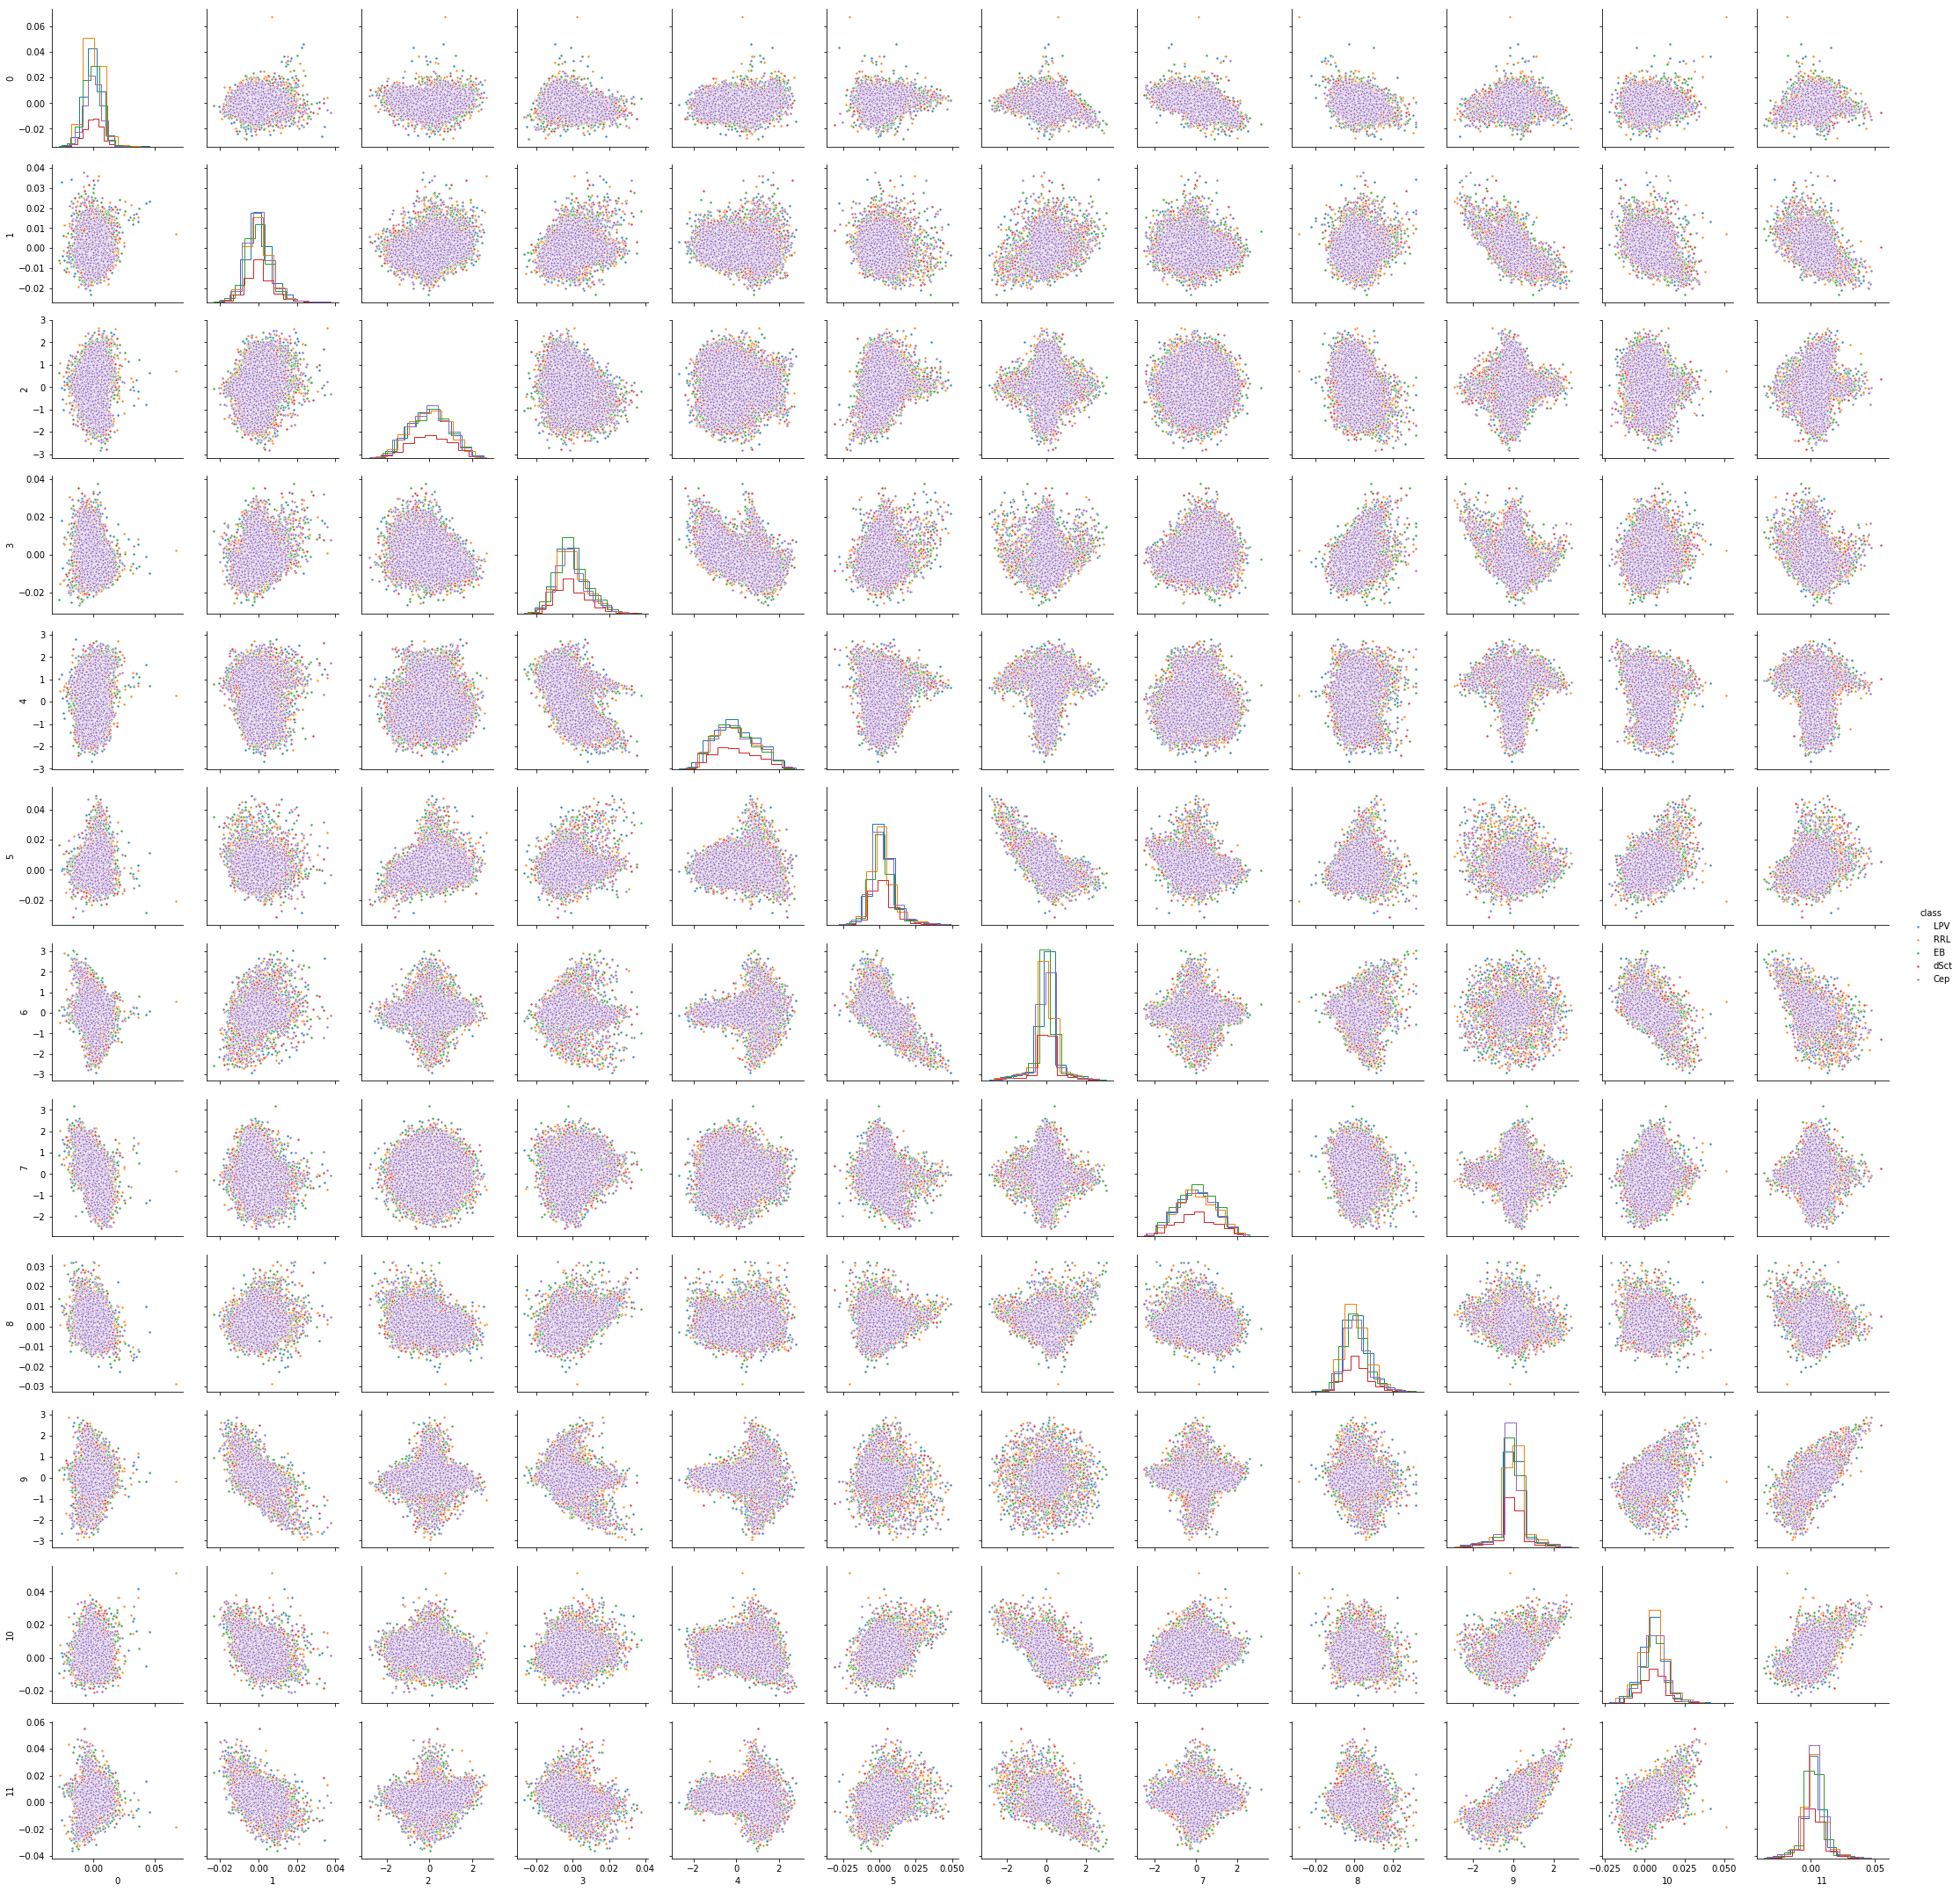

In [49]:
sb.pairplot(mu.sample(10000), hue='class', diag_kind="hist", markers=".",
            plot_kws=dict(s=40, edgecolors='face', alpha=.9),
            diag_kws=dict(histtype='step'))
plt.show()

### tSNE projection to 2D

In [10]:
def scatter_hue(x, y, labels):
    fig = plt.figure(figsize=(8,6))
    c = cm.rainbow(np.linspace(0,1,len(set(labels))))
    for i, cls in enumerate(set(labels)):
        idx = np.where(labels == cls)[0]
        plt.scatter(x[idx], y[idx], marker='.', s=8,
                    color=c[i], alpha=.4, label=cls)
    plt.xlabel('embedding 1')
    plt.ylabel('embedding 2')
    plt.legend(loc='best')
    plt.show()

In [50]:
to_tsne = mu.sample(10000)
tsne = TSNE(n_components=2, perplexity=20, 
              random_state=10, verbose=2)
mu_embed = tsne.fit_transform(to_tsne.iloc[:,:-1].values)
print('Embeding shape: ', mu_embed.shape)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.733s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.217104
[t-SNE] Computed conditional probabilities in 0.318s
[t-SNE] Iteration 50: error = 102.4668350, gradient norm = 0.0119714 (50 iterations in 8.736s)
[t-SNE] I

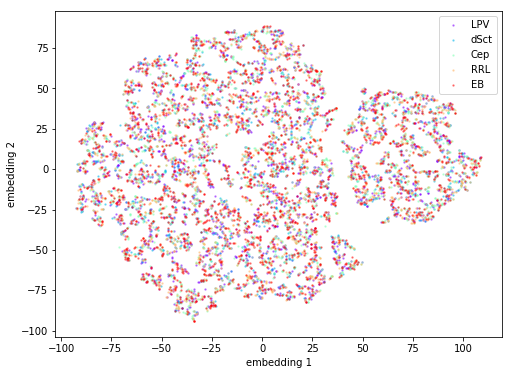

In [53]:
scatter_hue(mu_embed[:,0], mu_embed[:,1], to_tsne.loc[:,'class'].values)

# exploring the latent space

torch.Size([1, 150, 3]) torch.Size([1, 150, 3])


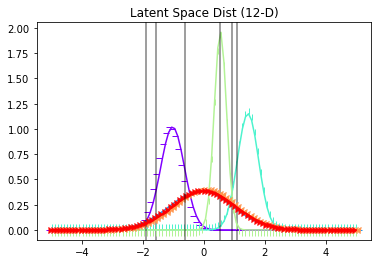

sampled latent vector: 
 [-1.5744994   0.9090346   1.0942795   0.53212446 -1.9103066  -0.6284591 ]


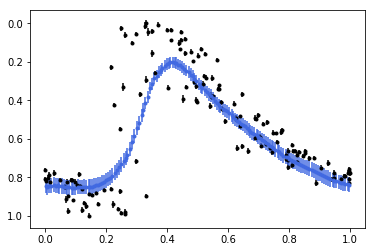

In [13]:
cls = 'RRL_RRab'

idx = dataset.meta[dataset.meta.subType == cls].sample(1).index
lc, label, onehot, pp = dataset[idx]
lc = torch.from_numpy(lc)
onehot = torch.from_numpy(onehot)
if cond:
    lchat, mu, logvar, z = vae(lc, c=onehot)
else:
    lchat, mu, logvar, z = vae(lc)
print(lc.shape, lchat.shape)
mu = mu.detach().numpy().flatten()
logvar = logvar.detach().numpy().flatten()
z = z.detach().numpy().flatten()
lchat = lchat.detach().numpy()
lc = lc.detach().numpy()

fig = plt.figure()
c = cm.rainbow(np.linspace(0, 1, len(mu)))
mkr = []
for i, (m, var, z_)  in enumerate(zip(mu, logvar, z)):
    x_ = np.linspace(-5, 5, 100)
    y_ = scipy.stats.norm.pdf(x_, m, np.exp(.5*var))
    plt.plot(x_, y_, color=c[i], marker=i)
    plt.axvline(z_, c='k', alpha=.5)
plt.title('Latent Space Dist (12-D)')
plt.show()

print('sampled latent vector: \n', z)

fig = plt.figure()
plt.errorbar(lc[0,:,0], lc[0,:,1], yerr=lc[0,:,2], c='k', fmt='.')
plt.errorbar(lchat[0,:,0], lchat[0,:,1], yerr=lchat[0,:,2], c='royalblue', fmt='.')
plt.gca().invert_yaxis()
plt.show()


In [14]:
cls = 'RRL'
idx = dataset.meta[dataset.meta.Type == cls].sample(1).index
lc, label, onehot, pp = dataset[idx]
lc = torch.from_numpy(lc)
onehot = torch.from_numpy(onehot)

if cond:
    lchat, mu, logvar, z = vae(lc, c=onehot)
else:
    lchat, mu, logvar, z = vae(lc)

z_n = z.detach().numpy().flatten()
lchat = lchat.detach().numpy()
lc = lc.detach().numpy()

p = figure(title="VAE %s" % (cls), plot_height=300, 
           plot_width=600, y_range=(1.1,-0.1),
           background_fill_color='#efefef')
#r = p.errorbar(x, y, color="royalblue", line_width=1.5, alpha=0.8)
real = p.circle(lc[0,:,0], lc[0,:,1], color='black', size=5, line_alpha=0)
pred = p.circle(lchat[0,:,0], lchat[0,:,1], color='royalblue', size=5, line_alpha=0)

# create the coordinates for the errorbars
err_xs = []
err_ys = []
for x, y, yerr in zip(lc[0,:,0], lc[0,:,1], lc[0,:,2]):
    err_xs.append((x, x))
    err_ys.append((y - yerr, y + yerr))

# plot them
p.multi_line(err_xs, err_ys, color='black')
# show(p)

GlyphRenderer(id='1100', ...)

In [15]:
def update(label, z0=z_n[0], z1=z_n[1], z2=z_n[2], z3=z_n[3],
                  z4=z_n[4], z5=z_n[5]):

    z_ = z.clone()
    z_[0,0] = z0
    z_[0,1] = z1
    z_[0,2] = z2
    z_[0,3] = z3
    z_[0,4] = z4
    z_[0,5] = z5
    #z_[0,6] = z6
    #z_[0,7] = z7
    #z_[0,8] = z8
    #z_[0,9] = z9
    #z_[0,10] = z10
    #z_[0,11] = z11
    print(z_)
    if cond:
        lchat = vae.decoder(z_, c=onehot)
    else:
        lchat = vae.decoder(z_)
    lchat = lchat.detach().numpy()
    
    pred.data_source.data['x'] = lchat[0,:,0]
    pred.data_source.data['y'] = lchat[0,:,1]
    
    push_notebook()

In [16]:
show(p, notebook_handle=True)
subtypes = dataset.meta.subType.unique().tolist()
interact(update, label=['RRL','LPV','Cep','EB','dSct'], 
         z0=(-5,5,.01), z1=(-5,5,.01), z2=(-5,5,.01), z3=(-5,5,.01),
         z4=(-5,5,.01), z5=(-5,5,.01))

interactive(children=(Dropdown(description='label', options=('RRL', 'LPV', 'Cep', 'EB', 'dSct'), value='RRL'),…

<function __main__.update(label, z0=-1.4797893, z1=0.23190577, z2=-1.4861536, z3=0.49163634, z4=0.83062047, z5=1.2256498)>

In [261]:
x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)

p = figure(title="simple line example", plot_height=300, plot_width=600, y_range=(-5,5),
           background_fill_color='#efefef')
r = p.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    elif f == "tanh":func = np.tanh
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()

show(p, notebook_handle=True)

interact(update, f=["sin", "cos", 'tanh'], w=(0,50), A=(1,10), phi=(0, 20, 0.1))

interactive(children=(Dropdown(description='f', options=('sin', 'cos', 'tanh'), value='sin'), IntSlider(value=…

<function __main__.update(f, w=1, A=1, phi=0)>